<h1 align="center"><font size="5">Classification with Python</font></h1>


We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [ ]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

In [4]:
### Load Data From CSV File


In [5]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [6]:
df.shape

(346, 10)

### Convert to date time object


In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [9]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y
!pip install seaborn

In [10]:
conda install seaborn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


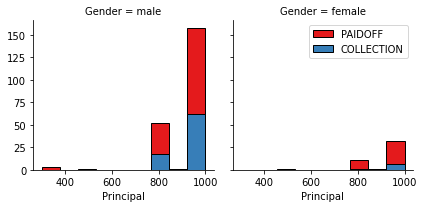

In [11]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

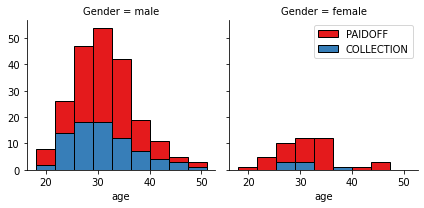

In [12]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


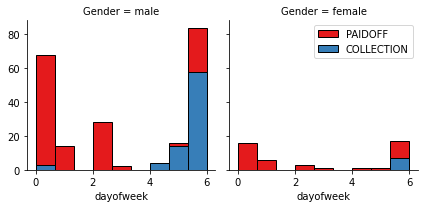

In [13]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [14]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [16]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [21]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [22]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [23]:
# We split the X into train and test to find the best k
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [24]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

In [25]:
# just for sanity chaeck
yhat = neigh.predict(X_test)
yhat[0:5]


array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [26]:
# Best k
from sklearn import metrics
Ks=15
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    
print(mean_acc)
print('Best Accuracy is with neighbor',mean_acc.argmax()+1)
print('Best Accuracy is',mean_acc.max())


[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286 0.67142857 0.7        0.72857143
 0.7        0.7       ]
Best Accuracy is with neighbor 7
Best Accuracy is 0.7857142857142857


In [27]:
#F1 Score & Jaccard Score For KNN with best k neighbors
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

neigh = KNeighborsClassifier(n_neighbors=7).fit(X_train,y_train)
yhat = neigh.predict(X_test)

print("F1-Score:",f1_score(y_test,yhat,average='weighted'))
print("Jaccard Score:",jaccard_score(y_test,yhat,pos_label='PAIDOFF'))

F1-Score: 0.7766540244416351
Jaccard Score: 0.765625


# Decision Tree

In [28]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=3)
print('X-trainset:',X_train.shape)
print('y-trainset:',y_train.shape)
#modeling
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree
loanTree.fit(X_train,y_train)

X-trainset: (242, 8)
y-trainset: (242,)


DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [29]:
#Prediction
predTree=loanTree.predict(X_test)
print("Predicted--->",predTree[0:5])
print("Actual---.",y_test[0:5])

Predicted---> ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Actual---. ['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


In [30]:
#Evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTree's Accuracy:",metrics.accuracy_score(y_test,predTree))

DecisionTree's Accuracy: 0.7019230769230769


In [31]:
#Jaccard Score
from sklearn.metrics import jaccard_score
print('Jaccard_Score:',jaccard_score(y_test,predTree,pos_label='PAIDOFF'))

#F1 Score
from sklearn.metrics import f1_score
print('F1_Score:',f1_score(y_test,predTree,average='weighted'))

Jaccard_Score: 0.6666666666666666
F1_Score: 0.7000725689404935


In [32]:
!pip install graphviz
!pip install pydotplus

     |████████████████████████████████| 278 kB 13.3 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=c6610e3c13b39e719c3925180d35e1d33103d0caac8cdc7a9968bea92fb912cc
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


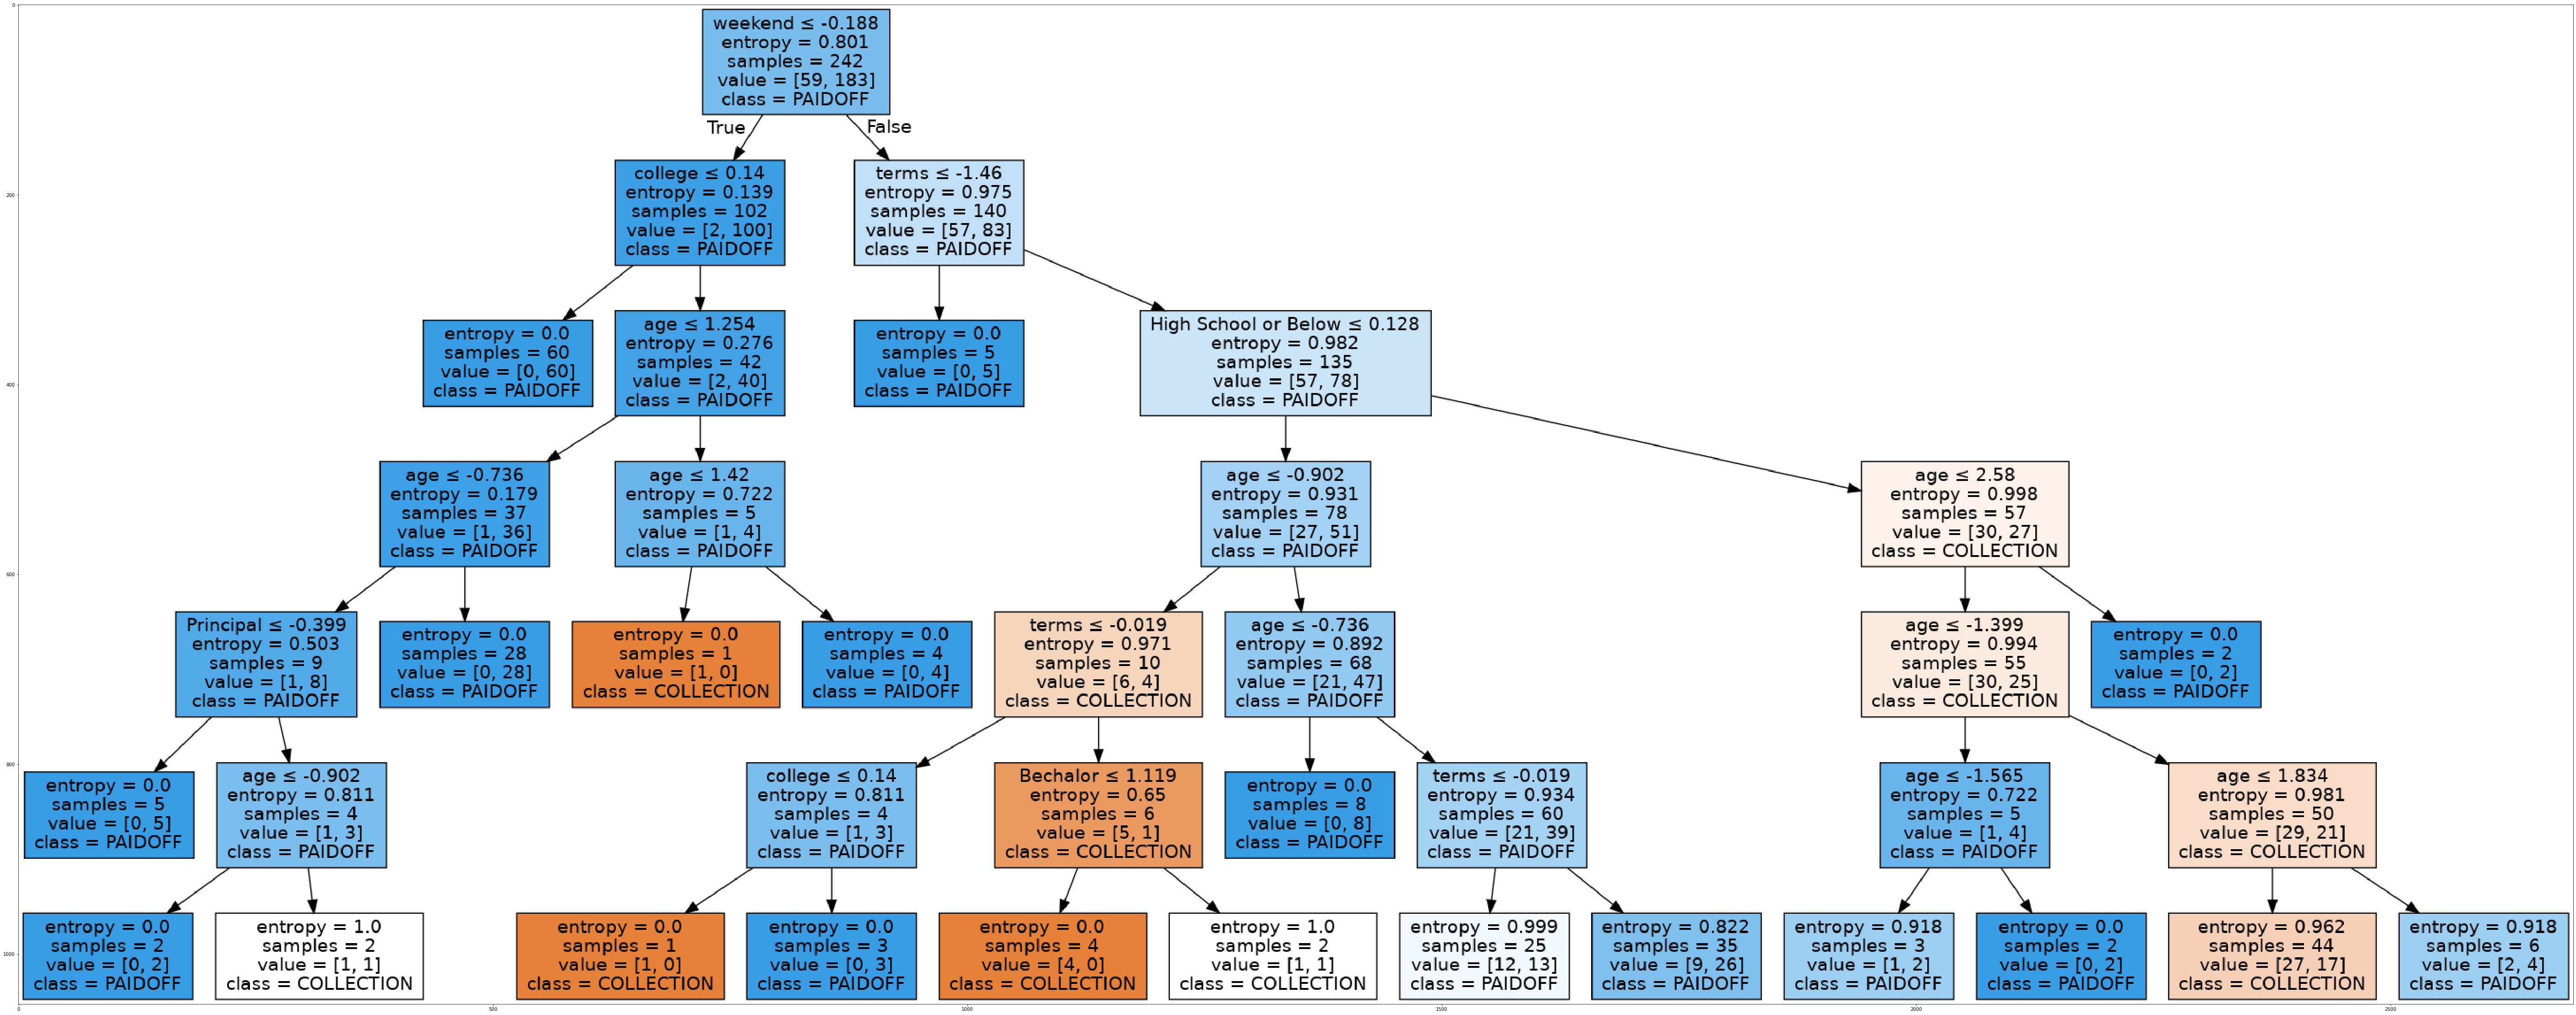

In [33]:
#Visualization
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

dot_data=StringIO()
filename="loanTree.png"
featureNames = Feature.columns[:]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [34]:
#svm
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)
from sklearn import svm
knls=['linear','rbf','sigmoid']
mean_accuracy=np.zeros(len(knls))
for kernel in knls:
    clf=svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    svm_predict = clf.predict(X_test)
    mean_accuracy[knls.index(kernel)] = metrics.accuracy_score(y_test, svm_predict)

print( "The best accuracy was :: ", mean_accuracy.max())


The best accuracy was ::  0.7857142857142857


<h3>For RBF</h3>

In [37]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_trainset, y_trainset) 

svm_pred = clf.predict(X_testset)
svm_pred [0:5]

from sklearn.metrics import jaccard_score
print('Jaccard_Score:',jaccard_score(y_testset, svm_pred,pos_label='PAIDOFF'))

from sklearn.metrics import f1_score
print('F1_Score:',f1_score(y_testset,svm_pred,average='weighted'))

Jaccard_Score: 0.7272727272727273
F1_Score: 0.7275882012724117


<h3>For Linear</h3>

In [42]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_trainset, y_trainset) 

svm_pred = clf.predict(X_testset)
svm_pred [0:5]

from sklearn.metrics import jaccard_score
print('Jaccard Score:',jaccard_score(y_testset, svm_pred,pos_label='PAIDOFF'))

from sklearn.metrics import f1_score
print('F1_Score:',f1_score(y_test,svm_pred,average='weighted'))

Jaccard Score: 0.7857142857142857
F1_Score: 0.6914285714285714


<h3>For Sigmoid</h3>

In [40]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn import svm
clf = svm.SVC(kernel='sigmoid')
clf.fit(X_trainset, y_trainset) 

svm_pred = clf.predict(X_testset)
svm_pred [0:5]

from sklearn.metrics import jaccard_score
print('Jaccard Score:',jaccard_score(y_testset, svm_pred,pos_label='PAIDOFF'))

from sklearn.metrics import f1_score
print('F1_Score:',f1_score(y_test,svm_pred,average='weighted'))

Jaccard Score: 0.7391304347826086
F1_Score: 0.6892857142857144


# Logistic Regression


In [ ]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set shape:', X_trainset.shape,  y_trainset.shape)
print ('Test set shape:', X_testset.shape,  y_testset.shape)


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainset,y_trainset)
LR
lr_predict = LR.predict(X_testset)
lr_predict

from sklearn.metrics import jaccard_score
print("Jaccard Score :: ",jaccard_score(y_testset, lr_predict,pos_label='PAIDOFF') )


from sklearn.metrics import f1_score
print("F1 Score :: ",f1_score(y_testset, lr_predict, average='weighted'))


Jaccard Score ::  0.6764705882352942
F1 Score ::  0.6670522459996144


In [44]:
lr_prob = LR.predict_proba(X_testset)
lr_prob

array([[0.5034238 , 0.4965762 ],
       [0.45206111, 0.54793889],
       [0.30814132, 0.69185868],
       [0.34259428, 0.65740572],
       [0.32025894, 0.67974106],
       [0.31680537, 0.68319463],
       [0.48830185, 0.51169815],
       [0.47823073, 0.52176927],
       [0.34259428, 0.65740572],
       [0.4934056 , 0.5065944 ],
       [0.33806706, 0.66193294],
       [0.49662231, 0.50337769],
       [0.24891907, 0.75108093],
       [0.3419095 , 0.6580905 ],
       [0.43751789, 0.56248211],
       [0.25760497, 0.74239503],
       [0.52357188, 0.47642812],
       [0.30450278, 0.69549722],
       [0.50166363, 0.49833637],
       [0.3195971 , 0.6804029 ],
       [0.44276988, 0.55723012],
       [0.49410185, 0.50589815],
       [0.51350333, 0.48649667],
       [0.47203498, 0.52796502],
       [0.40944694, 0.59055306],
       [0.50846442, 0.49153558],
       [0.51098415, 0.48901585],
       [0.37457647, 0.62542353],
       [0.50418423, 0.49581577],
       [0.25299635, 0.74700365],
       [0.

<h4>Logloss</h4>

In [45]:
#logloss
from sklearn.metrics import log_loss
log_loss(y_testset, lr_prob)

0.5772287609479654

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.766   | 0.776    | NA      |
| Decision Tree      | 0.667   | 0.700    | NA      |
| SVM                | 0.727   | 0.727    | NA      |
| LogisticRegression | 0676    | 0.667    | 0.577   |
